In [194]:
# Célula 1: Importações de Bibliotecas e Módulos

import pandas as pd
from sklearn import impute, model_selection
from sklearn.experimental import enable_iterative_imputer # Necessário para o IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import missingno as msn
from seaborn import jointplot
import matplotlib.pyplot as plt

In [195]:
# Célula 2: Carga de Dados e Inspeção
df = pd.read_excel('titanic3.xls')

# Inspeção inicial (opcional, mas bom para checagem)
print("Formato dos dados:", df.shape)
print("Cabeçalho:")
df.head()

Formato dos dados: (1309, 14)
Cabeçalho:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [196]:
# Célula 3: Definições das Funções do Pipeline (COM CORREÇÃO DO WARNING)

def tweak_titanic(df):
    """Realiza a limpeza inicial e o one-hot encoding."""
    cols_to_drop = [
        'name', 'ticket', 'home.dest', 'boat', 'body', 'cabin',
    ]
    df = df.drop(columns=cols_to_drop)
    
    # Preenche NaNs na coluna 'embarked' (Categórica) com a Moda antes de fazer o get_dummies
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
    
    df = pd.get_dummies(df, drop_first=True)
    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    """Divide, Imputa (Iterative) e Escala os dados de treino e teste."""
    
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    
    # Colunas que serão imputadas com IterativeImputer (apenas as de fato numéricas)
    num_cols_to_impute = ['age', 'fare'] 
    
    # 1. Imputação de Valores Ausentes
    fi = impute.IterativeImputer(random_state=42)
    X_train.loc[:, num_cols_to_impute] = fi.fit_transform(X_train[num_cols_to_impute])
    X_test.loc[:, num_cols_to_impute] = fi.transform(X_test[num_cols_to_impute])
    
    # 2. Preenchimento de qualquer NaN remanescente com a mediana
    meds = X_train.median()
    X_train = X_train.fillna(meds)
    X_test = X_test.fillna(meds)
    
    # 3. Escalonamento (BLOCO CORRIGIDO AQUI)
    if std_cols:
        std = StandardScaler()
        # Converte para float antes da atribuição para evitar o FutureWarning
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols].astype(float))
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols].astype(float))
        
    return X_train, X_test, y_train, y_test

In [197]:
# Célula 4: Aplicação do Pipeline e Divisão Final

# 1. Aplica a limpeza e o encoding
ti_df = tweak_titanic(df) 

# 2. Colunas para Escalonamento
std_cols = "pclass age sibsp fare".split() 

# 3. Executa a divisão, imputação e escalonamento
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Checagem final (opcional)
print("\nFormato do conjunto de Treino:", X_train.shape)
print("Valores ausentes em X_train:", X_train.isnull().sum().sum())


Formato do conjunto de Treino: (916, 8)
Valores ausentes em X_train: 0


C:\Users\Marcio\AppData\Local\Temp\ipykernel_13488\424554829.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.82524778  0.82524778 -0.36331663  0.82524778  0.82524778  0.82524778
  0.82524778  0.82524778  0.82524778  0.82524778 -0.36331663  0.82524778
  0.82524778 -1.55188105  0.82524778  0.82524778  0.82524778  0.82524778
 -0.36331663 -1.55188105 -1.55188105 -1.55188105  0.82524778  0.82524778
 -1.55188105 -1.55188105  0.82524778  0.82524778 -0.36331663  0.82524778
  0.82524778  0.82524778 -1.55188105 -1.55188105  0.82524778  0.82524778
  0.82524778  0.82524778  0.82524778 -0.36331663 -0.36331663 -0.36331663
 -1.55188105  0.82524778 -1.55188105  0.82524778 -0.36331663 -1.55188105
 -1.55188105 -0.36331663  0.82524778  0.82524778 -0.36331663  0.82524778
 -0.36331663  0.82524778 -0.36331663  0.82524778 -0.36331663 -1.55188105
 -0.36331663  0.82524778  0.82524778 -0.36331663 -1.55188105  0.82524778
 -1.5518810

In [198]:
# Célula 5: Modelagem e Avaliação (Modelo Baseline)

# Cria e treina o modelo Dummy
bm = DummyClassifier() 
bm.fit(X_train, y_train)

# Avalia a acurácia
accuracy = bm.score(X_test, y_test) 

print(f"Acurácia do modelo Dummy (Baseline): {accuracy:.4f}")

Acurácia do modelo Dummy (Baseline): 0.5700


In [199]:
# Célula 6: Comparação de Modelos com Validação Cruzada (CORRIGIDA)

# 1. Recombina os dados (necessário para a Validação Cruzada)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# 2. Importações de modelos (Garantindo que estão todos aqui)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import xgboost
import inspect # Importa o módulo inspect para verificar os argumentos aceitos

# 3. Lista de Modelos
MODELS = [
    DummyClassifier, 
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]

# 4. Loop de Comparação de Modelos
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
print(f"{'Modelo':22} {'AUC':5} {'STD':5}")
print("-" * 32)


for model in MODELS:
    # 5. Lógica de Inicialização: Verifica se o modelo aceita 'random_state'
    
    # Obtém os parâmetros que o construtor do modelo (o __init__) aceita
    params = inspect.signature(model.__init__).parameters
    
    if 'random_state' in params:
        # Inicializa o modelo passando random_state=42
        cls = model(random_state=42)
    else:
        # Inicializa o modelo sem o argumento random_state
        cls = model() 
    
    # 6. Validação Cruzada
    s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
    
    # 7. Imprime o resultado
    print(f"{model.__name__:22} AUC: "
          f"{s.mean():.3f} STD: {s.std():.2f}")

Modelo                 AUC   STD  
--------------------------------
DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.840 STD: 0.04
DecisionTreeClassifier AUC: 0.765 STD: 0.03
KNeighborsClassifier   AUC: 0.832 STD: 0.02
GaussianNB             AUC: 0.813 STD: 0.05
SVC                    AUC: 0.834 STD: 0.03
RandomForestClassifier AUC: 0.847 STD: 0.02
XGBClassifier          AUC: 0.851 STD: 0.02


In [200]:
# Célula 7: Treinamento e Avaliação do Random Forest (Com n_estimators=10)

from sklearn.ensemble import RandomForestClassifier # Importação limpa e direta

# 1. Cria o objeto do modelo
rf = RandomForestClassifier(
    n_estimators=10,  # Usando 10 estimadores
    random_state=42
)

# 2. Treinamento do modelo
rf.fit(X_train, y_train) 

# 3. Avaliação no conjunto de teste
score = rf.score(X_test, y_test)

# 4. Imprime o resultado
print(f"Acurácia do RandomForest (no conjunto de teste, com 10 árvores): {score:.4f}")

Acurácia do RandomForest (no conjunto de teste, com 10 árvores): 0.7863


In [201]:
# Célula 8: Grid Search (Ajuste de Hiperparâmetros - TENTANDO REDUZIR OVERFITTING)

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
# X_train e y_train devem estar carregados na memória

# 1. Inicializa o modelo base (COM random_state fixo)
rf4 = RandomForestClassifier(random_state=42)

# 2. Define o dicionário de parâmetros a serem testados
# NOVOS VALORES: Inclusão de max_depth e min_samples_leaf mais restritivos
params = {
    "max_features": [0.4, "sqrt"], 
    "n_estimators": [15, 200],
    
    # Valores mais restritivos para forçar a generalização (reduzir Overfitting)
    "min_samples_leaf": [5, 10, 20], 
    
    # NOVO PARÂMETRO: Limita a profundidade das árvores (muito eficaz contra Overfitting)
    "max_depth": [5, 8, None] # 5 e 8 são limites, None deixa ir até o fim
} 

# 3. Executa o Grid Search
cv = model_selection.GridSearchCV(
    rf4, 
    params, 
    n_jobs=-1, 
    scoring="accuracy", # Usando 'accuracy' como métrica, como no original
).fit(X_train, y_train)

# 4. Imprime os melhores parâmetros encontrados
print("Melhores parâmetros encontrados (tentando reduzir overfitting):")
print(cv.best_params_)

# 5. Armazena o melhor modelo encontrado
rf5 = cv.best_estimator_

Melhores parâmetros encontrados (tentando reduzir overfitting):
{'max_depth': None, 'max_features': 0.4, 'min_samples_leaf': 10, 'n_estimators': 200}


In [202]:
# Célula 9: Treinamento e Avaliação do RF Otimizado

# 1. Cria o objeto do modelo usando os melhores parâmetros do Grid Search
# O operador ** desempacota o dicionário cv.best_params_ em argumentos nomeados
# Isso garante que você use a combinação {'max_features': 'auto', 'min_samples_leaf': 0.1, 'n_estimators': 200}
rf5 = RandomForestClassifier(
    **cv.best_params_, 
    random_state=42 # Adiciona o random_state para reprodutibilidade
)

# 2. Treinamento
rf5.fit(X_train, y_train)

# 3. Avaliação no conjunto de teste
score = rf5.score(X_test, y_test)

# 4. Imprime o resultado
print(f"Acurácia do Random Forest Otimizado: {score:.4f}")

Acurácia do Random Forest Otimizado: 0.7939


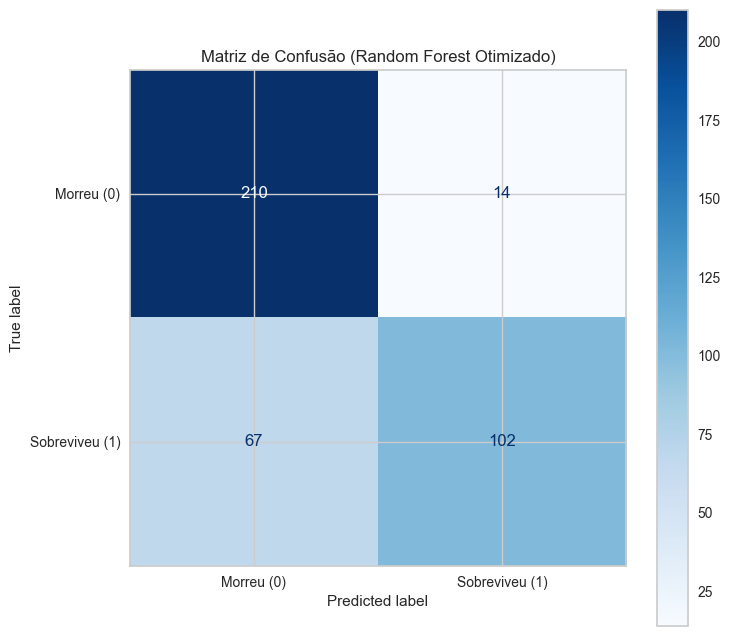

In [203]:
# Alternativa: Usando apenas Scikit-learn (Não depende de distutils)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = rf5.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Morreu (0)", "Sobreviveu (1)"]
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusão (Random Forest Otimizado)")
plt.show()

In [204]:
from sklearn.metrics import roc_auc_score

y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7705251479289941

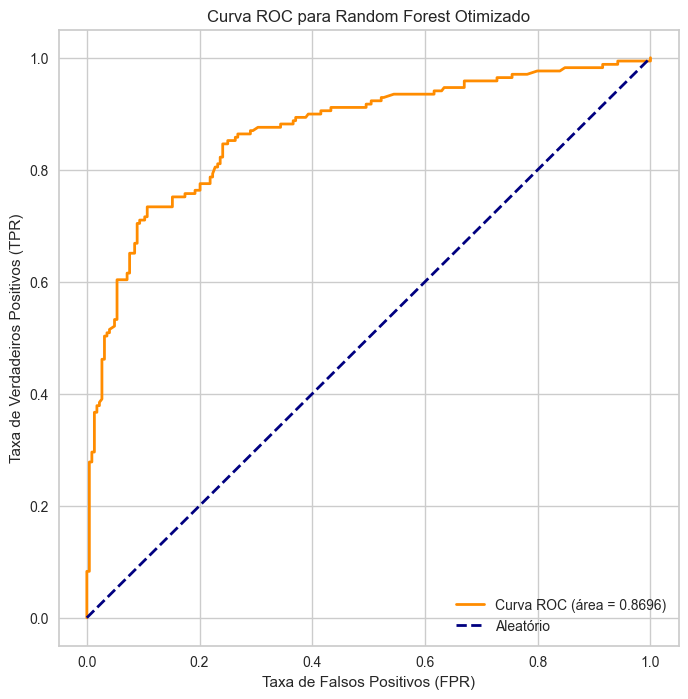

In [205]:
# Célula 12: Visualização da Curva ROC (Usando Scikit-learn e Matplotlib)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Obter as Probabilidades
# O ROC-AUC precisa da probabilidade de ser a classe positiva (Sobreviveu=1).
# O [:, 1] seleciona a coluna de probabilidade para a classe 1.
y_proba = rf5.predict_proba(X_test)[:, 1]

# 2. CALCULA A CURVA ROC
# 'fpr' (False Positive Rate) e 'tpr' (True Positive Rate) são os eixos do gráfico.
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 3. CALCULA A ÁREA SOB A CURVA (AUC)
# Este é o valor numérico que você já calculou (0.7888...)
roc_auc = auc(fpr, tpr)

# 4. PLOTA O GRÁFICO
plt.figure(figsize=(8, 8))

# Plota a Curva ROC do modelo
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Curva ROC (área = {roc_auc:.4f})')

# Plota a linha de referência (classificador aleatório, 50% de chance)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório') 

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para Random Forest Otimizado')
plt.legend(loc="lower right")

# Você pode salvar o arquivo aqui, se desejar.
plt.savefig("Curva_ROC_rf5.png", dpi=300, bbox_inches="tight")

plt.show()

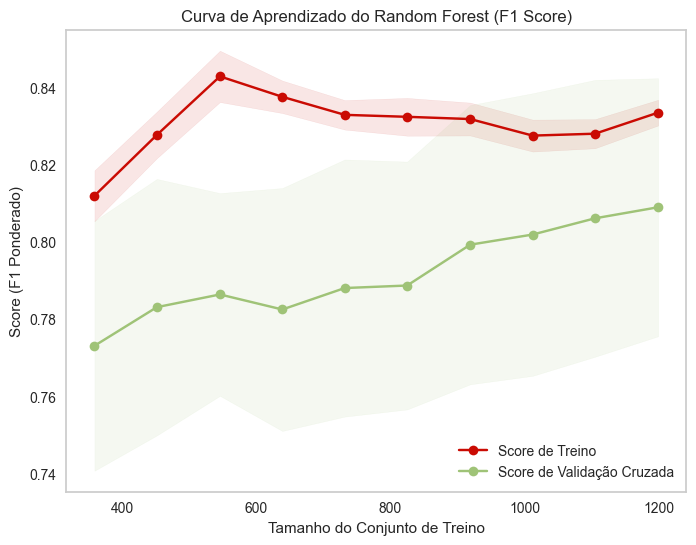

In [206]:
# Célula 13: Curva de Aprendizado (Usando Scikit-learn e Matplotlib)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

# X e y devem ser os dados de treino completos (antes de X_train/X_test)
# Usando X e y completos, como o Yellowbrick faz, para avaliar o modelo RF5

# 1. Define o número de folds e o tamanho das amostras de treino
cv = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
train_sizes = np.linspace(0.3, 1.0, 10)

# 2. Calcula as pontuações da curva de aprendizado
train_sizes_abs, train_scores, test_scores = learning_curve(
    rf5,                 # O modelo otimizado
    X,                   # Conjunto de dados COMPLETO (X)
    y,                   # Rótulos COMPLETOS (y)
    cv=cv,
    train_sizes=train_sizes,
    scoring='f1_weighted',
    n_jobs=-1,           # Usa todos os cores
    random_state=42
)

# 3. Calcula as médias e desvios padrão para plotagem
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. PLOTA A CURVA DE APRENDIZADO
plt.figure(figsize=(8, 6))
plt.title("Curva de Aprendizado do Random Forest (F1 Score)")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Score (F1 Ponderado)")

# Preenche a área de variação do treino
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

# Preenche a área de variação da validação (teste)
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Plota as médias
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
         label="Score de Treino")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
         label="Score de Validação Cruzada")

plt.legend(loc="best")
plt.grid()
plt.savefig("Curva_Aprendizado_rf5.png") # Salva o arquivo
plt.show()

c:\Users\Marcio\Desktop\projeto_ML\titanic\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


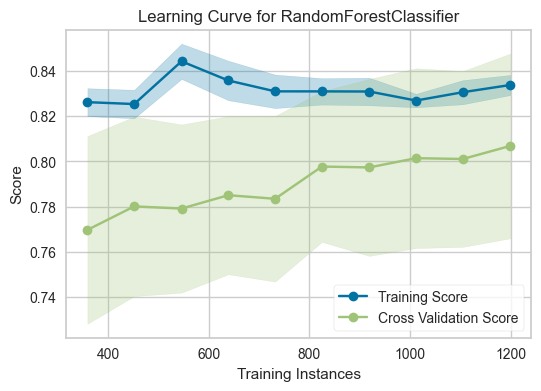

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [207]:
import numpy as np
from matplotlib import pyplot as plt
from yellowbrick.model_selection import LearningCurve
from  sklearn.model_selection import StratifiedKFold

fig, ax = plt.subplots(figsize=(6,4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf5,
    cv = cv,
    train_sizes=sizes,
    scoring='f1_weighted',
    n_jobs=4,
    ax=ax,
)
plt.gcf().savefig("titanic/images/mlpr_0306.png", dpi=300, bbox_inches="tight")
lc_viz.fit(X, y)
lc_viz.poof()


In [208]:
import janitor as jn
import pandas as pd

Xbad = pd.DataFrame(
    {
        "A": [1, None, 3],
        "  sales_numbers  ": [20.0, 30.0, None],
    }
)

In [209]:
jn.clean_names(Xbad)

,a,_sales_numbers_
0,1.0,20.0
1,NaN,30.0
2,3.0,NaN


In [210]:
def clean_col(name):
    return(
        name.strip().lower().replace(" ", "_")
    )

In [211]:
Xbad.rename(columns=clean_col)

,a,sales_numbers
0,1.0,20.0
1,NaN,30.0
2,3.0,NaN


In [212]:
Xbad.fillna(10)

,A,sales_numbers
0,1.0,20.0
1,10.0,30.0
2,3.0,10.0


In [213]:
X.describe().iloc[:, [0, -1]]

,pclass,fare
count,1309.000000,1309.000000
mean,-0.012831,-0.007945
std,0.995822,0.980205
min,-1.551881,-0.638974
25%,-0.363317,-0.489393
50%,0.825248,-0.365149
75%,0.825248,-0.046491
max,0.825248,9.066738


In [214]:
X.iloc[[1, 4], -3:]

,sex_male,embarked_Q,embarked_S
677,True,False,True
864,False,False,True


In [215]:
X.loc[[667, 864], "sex_male":]

,sex_male,embarked_Q,embarked_S
667,False,True,False
864,False,False,True


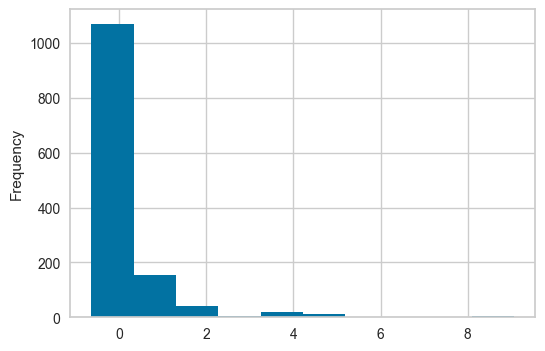

In [216]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind="hist", ax=ax)
fig.savefig("titanic/images/mlpr_0601.png", dpi=300)

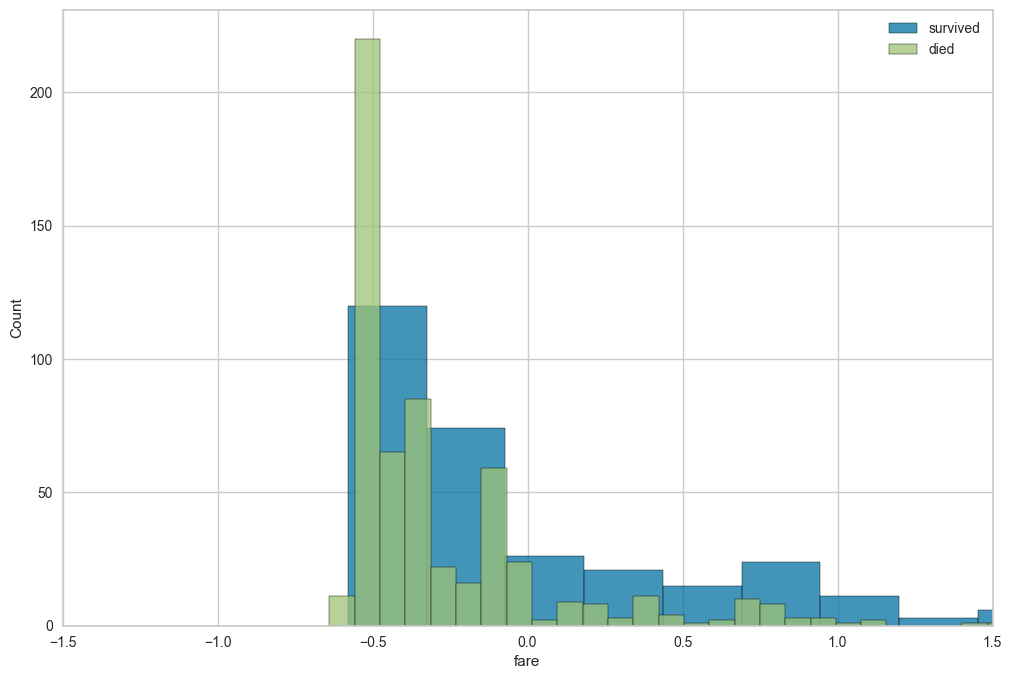

In [217]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
mask = y_train == 1
ax = sns.histplot(X_train[mask].fare, label="survived")
ax = sns.histplot(X_train[~mask].fare, label="died")
ax.set_xlim(-1.5, 1.5)
ax.legend()
fig.savefig("titanic/images/mlpr_0602.png", dpi=300, bbox_inches="tight")

c:\Users\Marcio\Desktop\projeto_ML\titanic\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


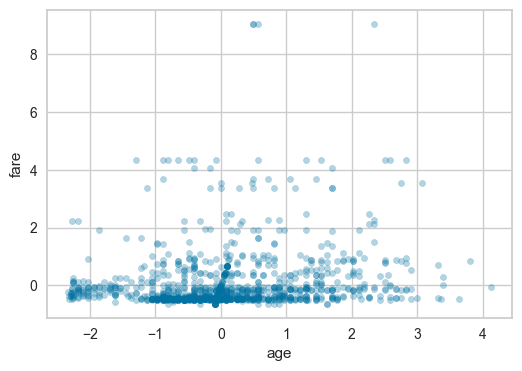

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))
X.plot.scatter(x="age", y="fare", ax=ax, alpha=0.3)
fig.savefig("titanic/images/mlpr_0603.png", dpi=300)

In [219]:
X.age.corr(X.fare)

np.float64(0.18440467929965196)

c:\Users\Marcio\Desktop\projeto_ML\titanic\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


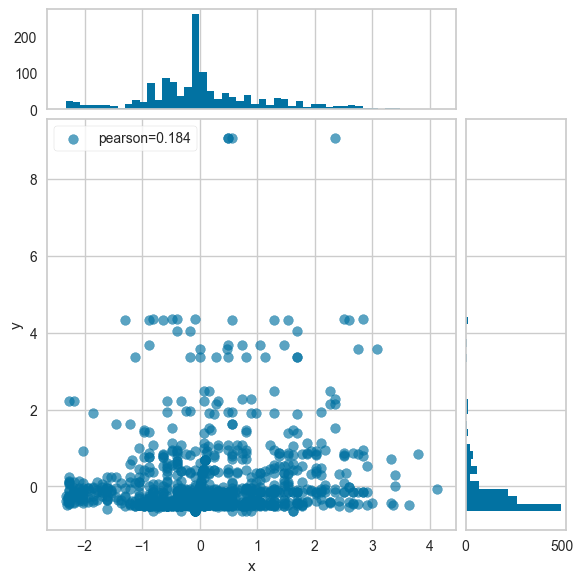

In [220]:
from yellowbrick.features import (
    JointPlotVisualizer,
)
fib, ax = plt.subplots(figsize=(6, 6))
jpv = JointPlotVisualizer(
    feature="age", target="fare"
)
jpv.fit(X["age"], X["fare"])
jpv.poof()
fib.savefig("titanic/images/mlpr_0604.png", dpi=300)

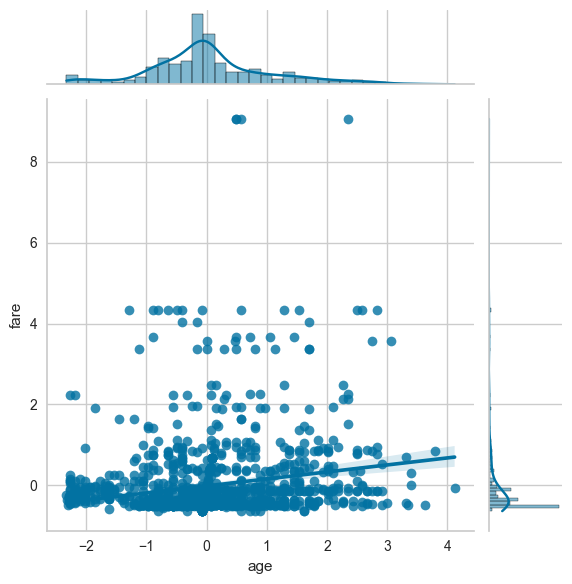

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns # O jointplot é sns.jointplot

# ... (Assumindo que X e y estão definidos) ...

# 1. LINHA ORIGINAL MANTIDA: Cria uma figura e eixos vazios (o que causa o gráfico vazio)
fig, ax = plt.subplots(figsize=(6, 6))

new__df = X.copy()
new__df["target"] = y

# 2. CORREÇÃO DO TypeError: Nomeando x e y
p = sns.jointplot(
    x="age",             # Adicionado 'x='
    y="fare",            # Adicionado 'y='
    data=new__df,
    kind="reg"
)
plt.close(fig) 
p.savefig("titanic/images/mlpr_0606.png", dpi=300)

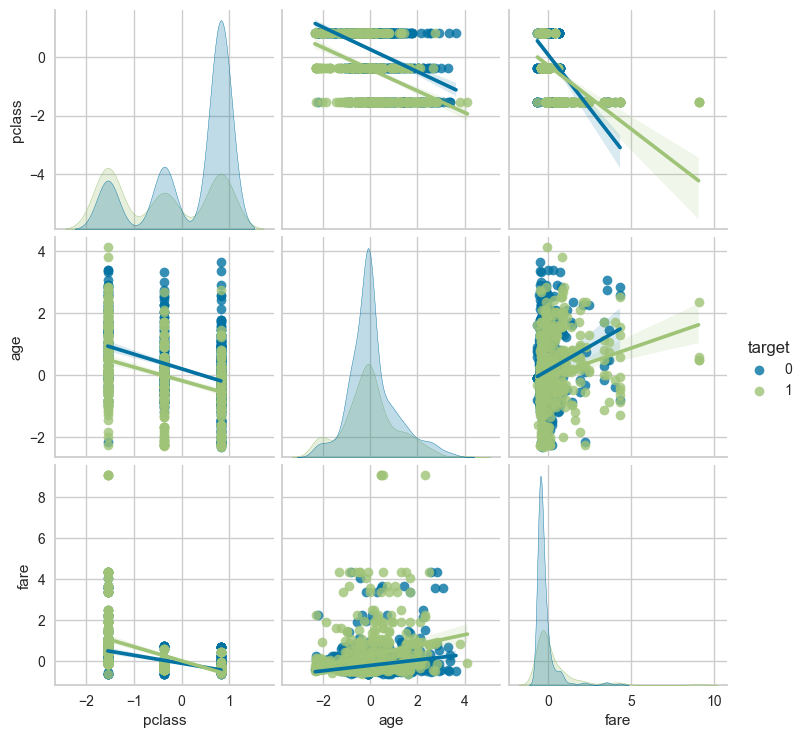

In [222]:
from seaborn import pairplot

fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y 
vars = ["pclass", "age", "fare"]
p = pairplot(
    new_df, vars=vars, hue="target", kind="reg"
)
plt.close(fig) 
p.savefig("titanic/images/mlpr_0606.png", dpi=300)

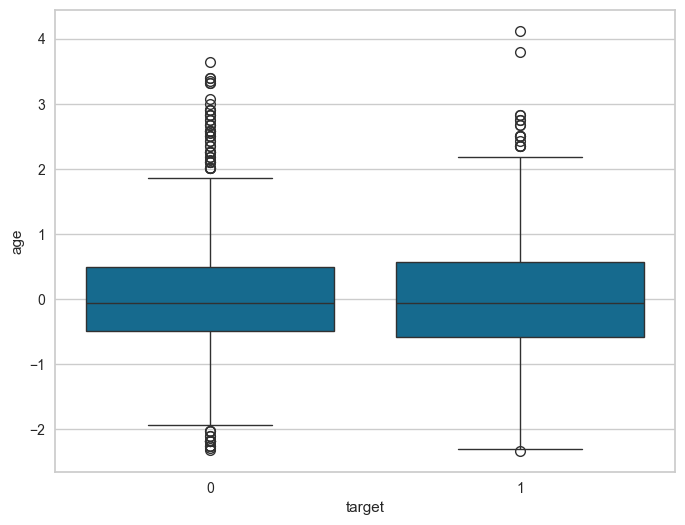

In [223]:
from seaborn import boxplot
fig, ax = plt.subplots(figsize=(8,6))
new_df = X.copy()
new_df["target"] = y 
boxplot(x="target", y="age", data=new_df)
fig.savefig("titanic/images/mlpr_0607.png", dpi=300)

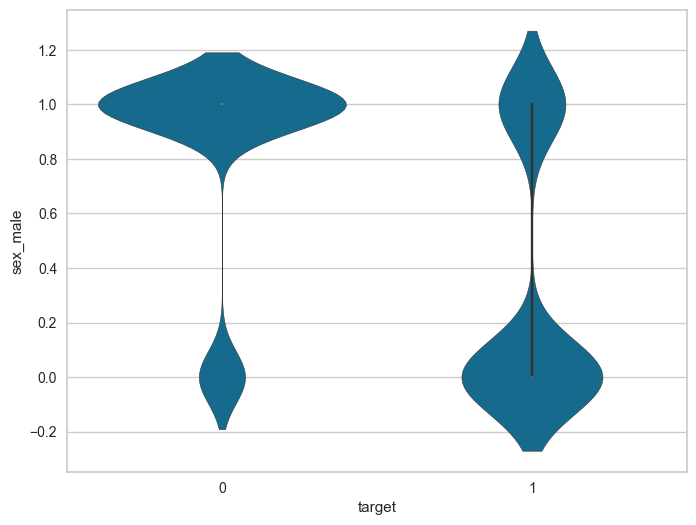

In [224]:
from seaborn import violinplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y 
violinplot(
    x="target", y="sex_male", data=new_df
)
fig.savefig("titanic/images/mlpr_0608.png", dpi=300)

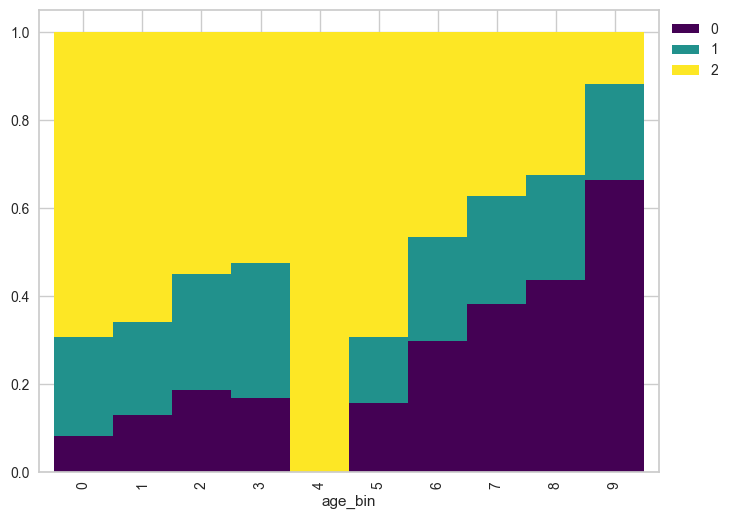

In [225]:
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
fig.savefig(
    "titanic/images/mlpr_0609.png",
    dpi=300,
    bbox_inches="tight",
)

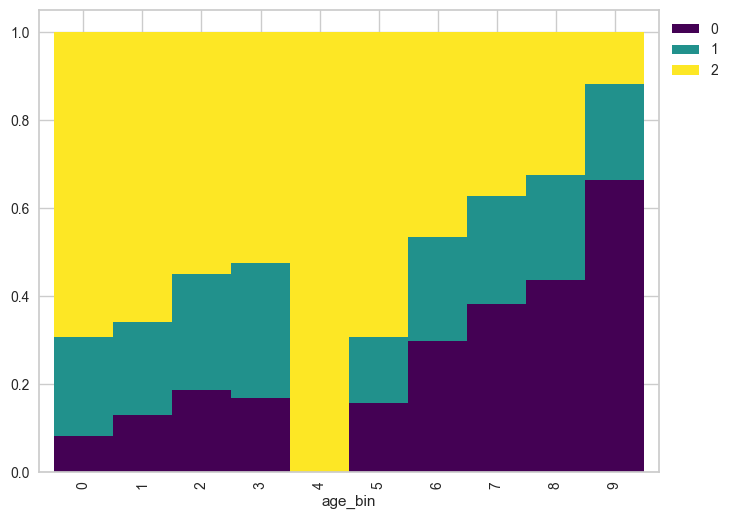

In [226]:
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .pipe(lambda df: pd.crosstab(
        df.age_bin, df.class_bin)
    )
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
fig.savefig(
    "titanic/images/mlpr_0609.png",
    dpi=300,
    bbox_inches="tight",
)

In [229]:
# Célula de Correção Aprimorada: (Colocar IMEDIATAMENTE antes da Célula 36)

import pandas as pd 
import numpy as np # Adicionado para tratar tipos

# 1. Restaura X e Y (concatenação)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# 2. CONVERSÃO CRÍTICA: Converte TODO o DataFrame X para float.
# Isso garante que não haja colunas 'object' ou 'int' que causem problemas internos.
X = X.astype(float) 

# 3. Trata quaisquer valores extremos ou infinitos (apenas por segurança)
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print("Variáveis X e Y restauradas e convertidas para float com sucesso.")
print(f"Novo formato de X: {X.shape} | Tipos em X (após correção): {X.dtypes.unique()}")

Variáveis X e Y restauradas e convertidas para float com sucesso.
Novo formato de X: (1309, 8) | Tipos em X (após correção): [dtype('float64')]


c:\Users\Marcio\Desktop\projeto_ML\titanic\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


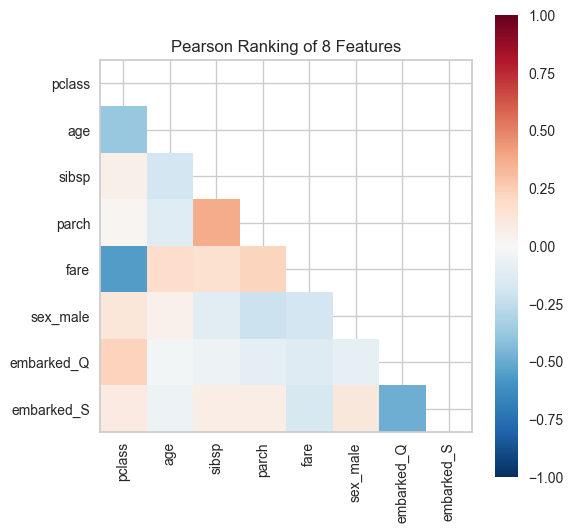

In [230]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(features=X.columns, algorithm="pearson")
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()
fig.savefig("titanic/images/mlpr_0610.png", dpi=300, bbox_inches="tight")